In [1]:
import numpy as np
import gzip
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.platform import gfile

In [2]:
def _read32(bytestream):
  dt = np.dtype(np.uint32).newbyteorder('>')
  return np.frombuffer(bytestream.read(4), dtype=dt)[0]

def extract_images(f):
    print('Extracting', f.name)
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %
                           (magic, f.name))
        num_images = _read32(bytestream)
        rows = _read32(bytestream)
        cols = _read32(bytestream)
        buf = bytestream.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        assert data.shape[3] == 1
        data = data.reshape(data.shape[0],data.shape[1] * data.shape[2])
        data = data.astype(np.float32)
        data = np.multiply(data, 1.0 / 255.0)
        return data
def extract_labels(f):
    with gzip.GzipFile(fileobj=f) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST label file: %s' %
                           (magic, f.name))
        num_items = _read32(bytestream)
        buf = bytestream.read(num_items)
        labels = np.frombuffer(buf, dtype=np.uint8)
        return labels

with gfile.Open("train-images-idx3-ubyte.gz", "rb") as f:
    train_images = extract_images(f)
with gfile.Open("train-labels-idx1-ubyte.gz", "rb") as f:
    train_labels = extract_labels(f)
with gfile.Open("t10k-images-idx3-ubyte.gz", "rb") as f:
    test_images = extract_images(f)
with gfile.Open("t10k-labels-idx1-ubyte.gz", "rb") as f:
    test_labels = extract_labels(f)

Extracting train-images-idx3-ubyte.gz
Extracting t10k-images-idx3-ubyte.gz


In [3]:
train_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [4]:
train_images = train_images.reshape( 60000, 28, 28 )
test_images = test_images.reshape( 10000, 28, 28 )

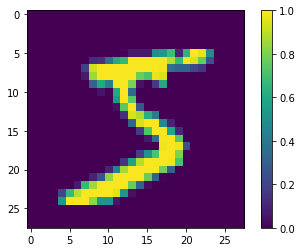

In [5]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

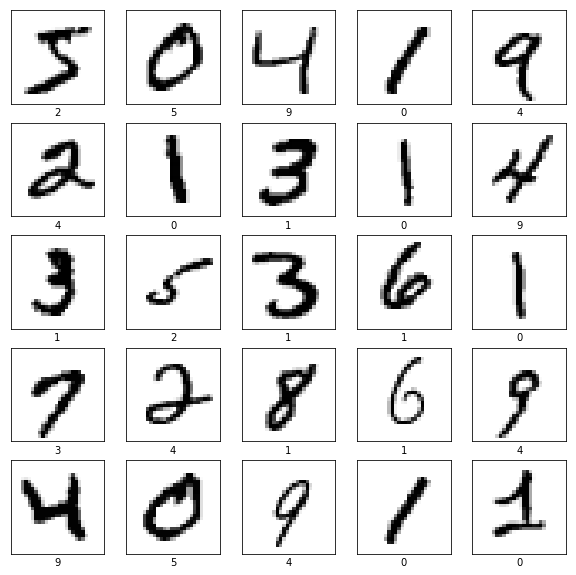

In [6]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[train_labels[i]])
plt.show()

In [7]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 3s 54us/sample - loss: 0.2578 - acc: 0.9263
Epoch 2/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.1137 - acc: 0.9672
Epoch 3/5
60000/60000 [==============================] - 3s 51us/sample - loss: 0.0781 - acc: 0.9766
Epoch 4/5
60000/60000 [==============================] - 3s 51us/sample - loss: 0.0590 - acc: 0.9814
Epoch 5/5
60000/60000 [==============================] - 3s 51us/sample - loss: 0.0459 - acc: 0.9859


In [10]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 32us/sample - loss: 0.0729 - acc: 0.9773
Test accuracy: 0.9773


In [11]:
predictions = model.predict(test_images)

In [12]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(test_labels[predicted_label],
                                100*np.max(predictions_array),
                                test_labels[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

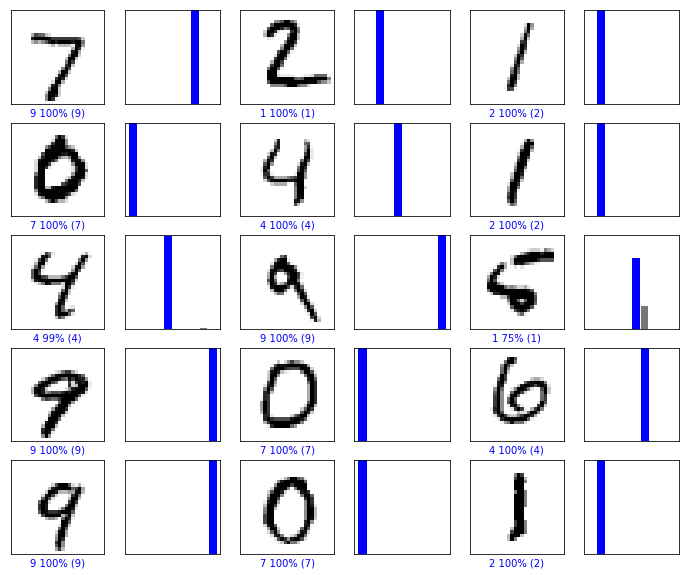

In [13]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()